**Don't Overfit**
A simple kernal for beginners.

In [65]:
#Import Libraries
import sys 
import pandas as pd 
import matplotlib 
import numpy as np 
import scipy as sc
import IPython
from IPython import display 
import sklearn

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

#Algorithms
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.svm import SVC

from scipy.stats import skew

#CV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#time
from time import time

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8



-------------------------


In [66]:
#Import Data
data_train = pd.read_csv('../input/train.csv')
data_test  = pd.read_csv('../input/test.csv')
data_submit = pd.read_csv('../input/sample_submission.csv')



In [67]:
#Add dfs
print('Shape Of train df:',data_train.shape)
print('Shape Of test df:',data_test.shape)
data_train_test = pd.concat([data_train, data_test]) #Remeber the index because we have to split data later (200000 in train )
print('Shape Of train test  df:',data_train_test.shape)

Shape Of train df: (250, 302)
Shape Of test df: (19750, 301)
Shape Of train test  df: (20000, 302)


In [68]:
#Remove id
print('Shape Of old train test df:',data_train_test.shape)
data_train_test.drop(['id'], axis=1, inplace = True)
print('Shape Of new train test df:',data_train_test.shape)

Shape Of old train test df: (20000, 302)
Shape Of new train test df: (20000, 301)


In [69]:
#Null Values
print('Null in  data:',data_train.isnull().sum().sum())
print('Null in  data:',data_test.isnull().sum().sum())

Null in  data: 0
Null in  data: 0


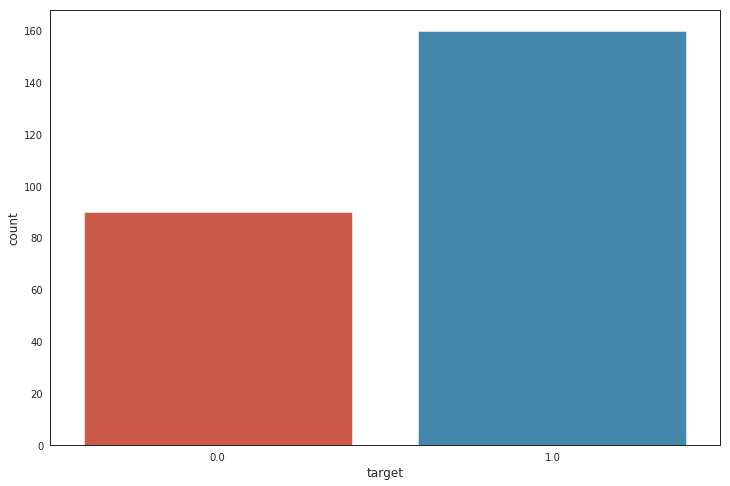

In [70]:
#PLot
sns.countplot(data_train['target'])

In [71]:
#Skewness in dataset
#As a general rule of thumb: If skewness is less than -1 or greater than 1, the distribution is highly skewed. 
#If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in data_train_test.columns:
    if data_train_test[i].dtype in numeric_dtypes: 
        numerics2.append(i)

skew_features = data_train_test[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
#skews

As we can see there is not much skewness in data. So we will not do anything.

In [72]:
#Correlation
#correlation of each varibale with target
def Correlation(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics2 = []
    crr = {}
    for y in df.columns:
        if df[y].dtype in numeric_dtypes:
            numerics2.append(y)
            for col in numerics2:
                if col != 'target':
                    crr[col] = np.corrcoef(df[col],df['target'])[1,0]
                    
    Crr_df = pd.DataFrame([crr])
    Crr_df = Crr_df.T
    Crr_df.columns = ['CorrCoef']
    Crr_df = Crr_df.sort_values(by='CorrCoef',ascending=False)
    return Crr_df
    
#Correlation(data_train)
#Very weak correlations 

We can observe that there is very weak correlations between target value and other variables. 

In [73]:
#Split data
X_train = data_train.iloc[:,data_train.columns != 'target']
y_train = data_train.iloc[:,data_train.columns == 'target']
X_train.drop(['id'], axis=1, inplace = True)
X_test = data_test.iloc[:,data_test.columns != 'target']
X_test.drop(['id'], axis=1, inplace = True)

Now we will try different models namely XGboost, Gradient Boosting, Random forest and Light Gradinet Boosting.
We will be using Grid search CV with Stratified Kfold. You can also try RandomizedSearchCV. We will tune the parameter for each model separatley and than will use best set of hyperparameter for each model. 

In [74]:
#XGboost
"""
params = {
        'min_child_weight':[3,4,5],
        'gamma': [1.565,1.575,1.585],
        'subsample':[.3600,.36250,.36500,],
        'colsample_bytree': [.94,.95,.96,.97,1],
        'max_depth': [3,4,5],
        'n_estimators' : range(475,575,25)
        }
#{'colsample_bytree': 0.95, 'gamma': 1.575, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 525, 'subsample': 0.3625}
#{'colsample_bytree': 0.95, 'gamma': 1.585, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 525, 'subsample': 0.3625} #0.6208333333333333


xgb = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1)


skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)



random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )
random_search.fit(X_train, y_train)

#print('\n All results:')
#print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
xgb_score_rs = random_search.best_score_ * 2 - 1
print('\n Best hyperparameters:')
print(random_search.best_params_)
results_random_search = pd.DataFrame(random_search.cv_results_)



grid_search  = GridSearchCV(xgb,params,verbose=3,scoring='roc_auc',n_jobs=-1,cv=skf.split(X_train,y_train))
grid_search.fit(X_train, y_train)

#print('\n All results:')
#print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score  with parameter combinations:' 
print(grid_search.best_score_ * 2 - 1)
xgb_score_gs = grid_search.best_score_ * 2 - 1
print('\n Best hyperparameters:')
print(grid_search.best_params_)
results_grid_search = pd.DataFrame(grid_search.cv_results_)


xgb1 = grid_search.best_estimator_


"""
"""
xgb1 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, gamma=1.585, learning_rate=0.02,
       max_delta_step=0, max_depth=3, min_child_weight=4, missing=None,
       n_estimators=525, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.3625)

start = time()
xgb1.fit(X_train,y_train.values.ravel())
end=time()
train_time_xgb1=end-start
y_pred_xgb1 = xgb1.predict_proba(X_test)
xgb1.score(X_train,y_train)

"""


0.996

In [75]:
#GradientBoosting

"""
params = {
        'loss': ['exponential'],#Tuned
        'learning_rate': [.001],#Tuned
        'subsample': [.3375],#Tuned
        'n_estimators' : [9400],#Tuned
        'criterion': ['friedman_mse'],#Tuned
        'min_samples_leaf': [2],#Tuned
        'min_samples_split': [6], #Tuned
        'min_weight_fraction_leaf': [0.3500],#Tuned
        'max_depth': [4],#Tuned
        'min_impurity_decrease': [0]#Tuned
        }

""""""
#Best hyperparameters:
#0.4887857707509884
#{'subsample': 0.4, 'n_estimators': 10000}
#0.4892343815513627
#{'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 10000, 'subsample': 0.4} 
#0.5186387141858841
#{'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.4, 'n_estimators': 10000, 'subsample': 0.4}
#0.5229489867225716
#{'criterion': 'friedman_mse', 'learning_rate': 0.001, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.4, 'n_estimators': 10000, 'subsample': 0.4}
#0.5370862334032145
#{'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'exponential', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.4, 'n_estimators': 10000, 'subsample': 0.4}
#0.53748427672956
#{'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'exponential', 'max_depth': 3, 'min_impurity_decrease': 0, 'min_samples_leaf': 3, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.4, 'n_estimators': 10000, 'subsample': 0.4}
#0.5847222222222224
#{'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'exponential', 'max_depth': 3, 
#'min_impurity_decrease': 0, 'min_samples_leaf': 3, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.4, 'n_estimators': 9500, 'subsample': 0.35}




gb = GradientBoostingClassifier()

skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1001)

"""
"""
random_search = RandomizedSearchCV(gb, param_distributions=params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

random_search.fit(X_train, y_train)

#print('\n All results:')
#print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
gb_score_rs = random_search.best_score_ * 2 - 1
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


"""
"""
grid_search  = GridSearchCV(gb,params,verbose=3,scoring='roc_auc',n_jobs=-1,cv=skf.split(X_train,y_train))
grid_search.fit(X_train, y_train)

#print('\n All results:')
#print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score  with parameter combinations:')
print(grid_search.best_score_ * 2 - 1)
gb_score_gs = grid_search.best_score_ * 2 - 1
print('\n Best hyperparameters:')
print(grid_search.best_params_)
results_grid_search = pd.DataFrame(grid_search.cv_results_)

#gb1 = grid_search.best_estimator_

"""

gb1  = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=6,
              min_weight_fraction_leaf=0.4, n_estimators=9500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.35, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

start = time()
gb1.fit(X_train,y_train.values.ravel())
end=time()
train_time_gb1=end-start
y_pred_gb1 = gb1.predict_proba(X_test)
gb1.score(X_train,y_train)


0.936

In [76]:
#RandomForest
"""
params = {
        'n_estimators' : [4500],
        #'criterion': ['gini','entropy'],
        'min_samples_split': [5],#Tuned 
        'min_samples_leaf': [3],#Tuned 
        'min_weight_fraction_leaf': [0.2],#Tuned #min_weight_fraction_leaf must in [0, 0.5]
        'max_depth': [5],#Tuned 
        'min_impurity_decrease':[0],
        'max_leaf_nodes':[50]#Tuned # max_leaf_nodes 1 must be either None or larger than 1
        }

rf = RandomForestClassifier()


skf = StratifiedKFold(n_splits=4, shuffle = True, random_state = 1001)

"""
"""
random_search = RandomizedSearchCV(rf, param_distributions=params, n_iter=10, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

random_search.fit(X_train, y_train)

#print('\n All results:')
#print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score  with parameter combinations:')
print(random_search.best_score_ * 2 - 1)
rf_score = random_search.best_score_ * 2 - 1
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)

rf1 = random_search.best_estimator_
"""
"""
grid_search  = GridSearchCV(rf,params,verbose=3,scoring='roc_auc',n_jobs=-1,cv=skf.split(X_train,y_train))
grid_search.fit(X_train, y_train)

#print('\n All results:')
#print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score  with parameter combinations:')
print(grid_search.best_score_ * 2 - 1)
gb_score_gs = grid_search.best_score_ * 2 - 1
print('\n Best hyperparameters:')
print(grid_search.best_params_)
results_grid_search = pd.DataFrame(grid_search.cv_results_)

rf1 = grid_search.best_estimator_

"""

"""
rf1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=50,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=5,
            min_weight_fraction_leaf=0.2, n_estimators=4500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
"""
"""
start = time()
rf1.fit(X_train,y_train.values.ravel())
end=time()
train_time_rf1=end-start
y_pred_rf1 = gb1.predict_proba(X_test)
rf1.score(X_train,y_train)
"""

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   18.8s finished



 Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=50,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=5,
            min_weight_fraction_leaf=0.2, n_estimators=4500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

 Best normalized gini score  with parameter combinations:
0.5438418972332015

 Best hyperparameters:
{'max_depth': 5, 'max_leaf_nodes': 50, 'min_impurity_decrease': 0, 'min_samples_leaf': 3, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.2, 'n_estimators': 4500}


0.64

In [77]:
#LGBoost
"""
params =  {  "max_depth": [],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,500,800,900,1000,1200],
              "n_estimators": [100,500,1000,5000,10000]
             }

lgb = LGBMClassifier()


skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)


random_search = RandomizedSearchCV(lgb, param_distributions=params, n_iter=10, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

random_search.fit(X_train, y_train)

#print('\n All results:')
#print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
lgb1_score = random_search.best_score_ * 2 - 1
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


#lgb1 = random_search.best_estimator_



grid_search  = GridSearchCV(lgb,params,verbose=3,scoring='roc_auc',n_jobs=-1,cv=skf.split(X_train,y_train))
grid_search.fit(X_train, y_train)

#print('\n All results:')
#print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score  with parameter combinations:')
print(grid_search.best_score_ * 2 - 1)
gb_score_gs = grid_search.best_score_ * 2 - 1
print('\n Best hyperparameters:')
print(grid_search.best_params_)
results_grid_search = pd.DataFrame(grid_search.cv_results_)

lgb1 = grid_search.best_estimator_

"""

"""
lgb1 = LGBMClassifier()

start = time()
lgb1.fit(X_train,y_train.values.ravel())
end=time()
train_time_lgb1=end-start
y_pred_lgb1 = gb1.predict_proba(X_test)
lgb1.score(X_train,y_train)
"""

1.0

Now we will compare Training time for each Model.

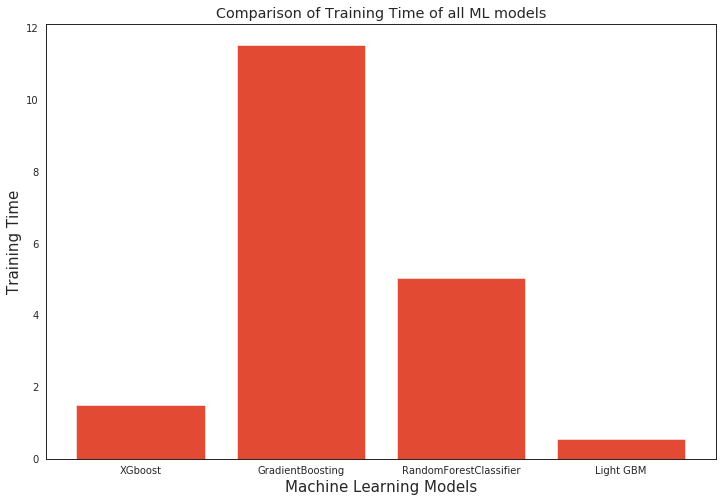

In [78]:
#Comparison of Training time
"""
model = [ 'XGboost','GradientBoosting','RandomForestClassifier','Light GBM']
Train_Time = [
    train_time_xgb1,
    train_time_gb1,
    train_time_rf1,
    train_time_lgb1
    
]
index = np.arange(len(model))
plt.bar(index, Train_Time)
plt.xlabel('Machine Learning Models', fontsize=15)
plt.ylabel('Training Time', fontsize=15)
plt.xticks(index, model, fontsize=10, )
plt.title('Comparison of Training Time of all ML models')
plt.show()
"""

In [81]:
#Comparison of Score
"""
model = [ 'XGboost','GradientBoosting','RandomForestClassifier','Light GBM']
Score = [
    xgb_score,
    gb_score,
    rf_score,
    lgb1_score
    
]
index = np.arange(len(model))
plt.bar(index, Score)
plt.xlabel('Machine Learning Models', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.xticks(index, model, fontsize=10, )
plt.title('Comparison of Score  of all ML models')
plt.show()
"""

"\nmodel = [ 'XGboost','GradientBoosting','RandomForestClassifier','Light GBM']\nScore = [\n    xgb_score,\n    gb_score,\n    rf_score,\n    lgb1_score\n    \n]\nindex = np.arange(len(model))\nplt.bar(index, Score)\nplt.xlabel('Machine Learning Models', fontsize=15)\nplt.ylabel('Score', fontsize=15)\nplt.xticks(index, model, fontsize=10, )\nplt.title('Comparison of Score  of all ML models')\nplt.show()\n"

In [80]:
#y_pred = (y_pred_xgb1+y_pred_gb1+y_pred_rf1+y_pred_lgb1)/4
y_pred = y_pred_gb1

data_submit['target'] = y_pred
data_submit.to_csv("submit.csv", index=False)